# Figure : CENP-C Intensity Analysis
## 72h vs 96h CENP-C Intensity Boxplot Visualization

This notebook generates the boxplot comparing CENP-C intensity between different experimental groups across timepoints.

In [1]:
# =============================================================================
# Figure 1: CENP-C Intensity Analysis Setup
# =============================================================================

# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import os
from skimage import io
from skimage.draw import disk

# Configure matplotlib for publication-quality plots
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']

In [2]:
# =============================================================================
# Image Analysis Functions for CENP-C Intensity Measurement
# =============================================================================

def get_cenpc_intensity_at_fish_common(root_dir: str, radius: int = 3):
    """
    Extract CENP-C intensity at DNA-FISH locations within segmented nuclei.
    
    This is the most sophisticated version that:
      - Finds TIFF files ending with '679.tif' (CENP-C channel)
      - Loads DNA-FISH centroids from 'intermediate_results/dna_fish_centroids.npy'
      - Loads nuclear segmentation from 'intermediate_results/segmentation.npy'
      - Only measures intensity for centroids within segmented nuclear regions
    
    Parameters:
    -----------
    root_dir : str
        Path to directory containing experimental subfolders
    radius : int, default=3
        Radius of circular region for intensity measurement
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame with columns ['folder', 'mean_intensity']
    """
    folders = []
    mean_vals = []

    # Process each subfolder
    for sub in os.listdir(root_dir):
        folder = os.path.join(root_dir, sub)
        if not os.path.isdir(folder):
            continue

        # Define file paths
        inter = os.path.join(folder, 'intermediate_results')
        tif_file = next((f for f in os.listdir(folder) if f.endswith('679.tif')), None)
        cent_path = os.path.join(inter, 'dna_fish_centroids.npy')
        seg_path = os.path.join(inter, 'segmentation.npy')

        # Check if all required files exist
        if not (tif_file and os.path.exists(cent_path) and os.path.exists(seg_path)):
            continue

        # Load image data, centroids, and segmentation mask
        image = io.imread(os.path.join(folder, tif_file))
        centroids = np.load(cent_path).astype(int)
        seg_mask = np.load(seg_path).astype(int)
        
        # Extract image dimensions safely
        try:
            H, W = image.shape[-2], image.shape[-1]
        except IndexError:
            continue

        # Calculate intensity only for centroids within nuclear regions
        local_means = []
        for r, c in centroids:
            # Quality control: check if centroid is within image bounds and nuclear region
            if r < 0 or c < 0 or r >= H or c >= W or seg_mask[r, c] == 0:
                continue

            # Measure intensity in circular region around valid centroid
            rr, cc = disk((r, c), radius=radius, shape=(H, W))
            local_means.append(image[rr, cc].mean())

        # Store results if valid measurements were obtained
        if local_means:
            folders.append(sub)
            mean_vals.append(np.mean(local_means))

    # Return results as DataFrame
    return pd.DataFrame({
        'folder': folders,
        'mean_intensity': mean_vals
    })

def calc_mean_dnafish_intensity(root_dir: str, radius: int = 3):
    """
    Calculate overall mean CENP-C intensity at DNA-FISH locations across all folders.
    
    This function uses the most sophisticated analysis method that includes
    nuclear segmentation for quality control.
    
    Parameters:
    -----------
    root_dir : str
        Path to directory containing experimental subfolders
    radius : int, default=3
        Radius for intensity measurement
        
    Returns:
    --------
    tuple
        (overall_mean_intensity, detailed_dataframe)
    """
    df_intensities = get_cenpc_intensity_at_fish_common(root_dir, radius)
    overall_mean = np.mean(df_intensities['mean_intensity'])
    return overall_mean, df_intensities

In [3]:
# =============================================================================
# Define Data Paths for Figure 1
# =============================================================================

# Base directory paths for different experimental conditions
BASE_PATH = '/vf/users/sagarm2/cellpose_chr/PaperData/Worked/forPAPER/'

# Scramble control paths
scramble_paths = {
    '72h': f'{BASE_PATH}group1/72h/Scram_72h_CpC/',
    '96h': f'{BASE_PATH}group1/96h/scramb/'
}

# Experimental group paths
experimental_groups = {
    'group1': {
        '72h': f'{BASE_PATH}group1/72h/PCAT2_72h_CpC/',
        '96h': f'{BASE_PATH}group1/96h/PCAT2/'
    },
    'group2': {
        '72h': f'{BASE_PATH}group2/PCAT2-KD_72h/',
        '96h': f'{BASE_PATH}group2/PCAT2-KD_96h/'
    }
}

print("Data paths configured for Figure 1 analysis")

Data paths configured for Figure 1 analysis


In [4]:
# =============================================================================
# Calculate Normalization Factors from Scramble Controls
# =============================================================================

print("Computing scramble control means for normalization...")
scramble_means = {}

for timepoint, folder_path in scramble_paths.items():
    mean_val, _ = calc_mean_dnafish_intensity(folder_path, radius=3)
    scramble_means[timepoint] = mean_val
    print(f"  {timepoint}: {mean_val:.3f}")

Computing scramble control means for normalization...
  72h: 707.580
  72h: 707.580
  96h: 340.802
  96h: 340.802


In [5]:
# =============================================================================
# Process Experimental Data and Create Normalized Dataset
# =============================================================================

print("\nProcessing experimental groups...")
normalized_data_rows = []

for group_name, timepoints in experimental_groups.items():
    print(f"  Processing {group_name}...")
    
    for timepoint, folder_path in timepoints.items():
        # Calculate mean intensity for this condition
        _, intensity_df = calc_mean_dnafish_intensity(folder_path, radius=3)
        
        # Add metadata and normalize to scramble control
        intensity_df = intensity_df.copy()
        intensity_df['group'] = group_name
        intensity_df['time'] = timepoint
        intensity_df['normalized_intensity'] = (
            intensity_df['mean_intensity'] / scramble_means[timepoint]
        )
        
        # Store relevant columns
        normalized_data_rows.append(
            intensity_df[['group', 'time', 'normalized_intensity']]
        )
        
        print(f"    {timepoint}: {len(intensity_df)} samples processed")

# Combine all data into a single DataFrame
df_normalized = pd.concat(normalized_data_rows, ignore_index=True)
print(f"\nTotal samples in dataset: {len(df_normalized)}")
print(f"Groups: {df_normalized['group'].unique()}")
print(f"Timepoints: {df_normalized['time'].unique()}")

<tifffile.TiffPages @2097160> invalid offset to first page 2097160



Processing experimental groups...
  Processing group1...
    72h: 19 samples processed
    72h: 19 samples processed


<tifffile.TiffPages @2097160> invalid offset to first page 2097160


    96h: 32 samples processed
  Processing group2...
    72h: 19 samples processed
    72h: 19 samples processed
    96h: 32 samples processed

Total samples in dataset: 102
Groups: ['group1' 'group2']
Timepoints: ['72h' '96h']
    96h: 32 samples processed

Total samples in dataset: 102
Groups: ['group1' 'group2']
Timepoints: ['72h' '96h']


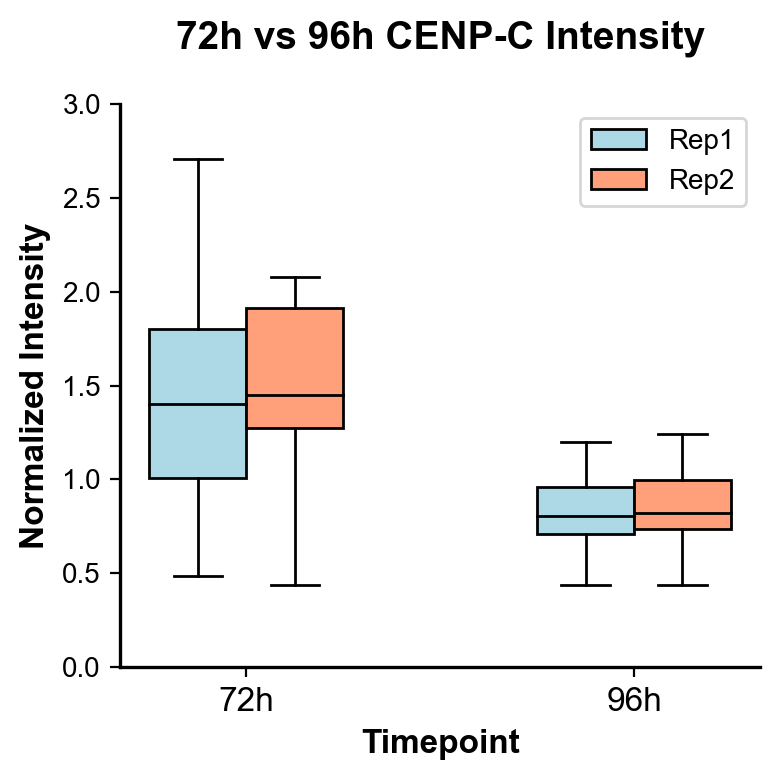

Figure 1: Boxplot visualization complete!
Data summary:
  Groups plotted: 2
  Timepoints: ['72h', '96h']
  Total data points: 102


In [6]:
# =============================================================================
# Figure 1: Create CENP-C Intensity Boxplot Visualization
# =============================================================================

# Extract unique groups and define plot parameters
groups_list = df_normalized['group'].unique()
timepoints = ['72h', '96h']
positions = np.arange(len(timepoints))
n_groups = len(groups_list)
box_width = 0.5 / n_groups

# Define color scheme for groups
colors = ['lightblue', 'lightsalmon']  # Rep1: light blue, Rep2: light salmon

# Create high-resolution figure
fig, ax = plt.subplots(figsize=(4, 4), dpi=200)

# Generate boxplots for each group
for group_idx, group_name in enumerate(groups_list):
    # Extract data for each timepoint for this group
    group_data = []
    for timepoint in timepoints:
        timepoint_data = df_normalized.loc[
            (df_normalized['group'] == group_name) & 
            (df_normalized['time'] == timepoint), 
            'normalized_intensity'
        ].values
        group_data.append(timepoint_data)
    
    # Calculate box positions for this group
    group_positions = positions + (group_idx - (n_groups-1)/2) * box_width
    
    # Create boxplot with custom styling
    boxplot_elements = ax.boxplot(
        group_data, 
        positions=group_positions, 
        widths=box_width, 
        patch_artist=True, 
        manage_ticks=False
    )
    
    # Style the boxes
    for box in boxplot_elements['boxes']:
        box.set_facecolor(colors[group_idx])
        box.set_edgecolor('black')
        box.set_linewidth(1.0)
    
    # Style other elements (whiskers, caps, medians)
    for element_type in ['whiskers', 'caps', 'medians']:
        for element in boxplot_elements[element_type]:
            element.set_color('black')
            element.set_linewidth(1.0)

# =============================================================================
# Format and Style the Plot
# =============================================================================

# Set x-axis labels and ticks
ax.set_xticks(positions)
ax.set_xticklabels(timepoints, fontsize=12)

# Set axis labels and title
ax.set_xlabel('Timepoint', fontsize=12, fontweight='bold')
ax.set_ylabel('Normalized Intensity', fontsize=12, fontweight='bold')
ax.set_title('72h vs 96h CENP-C Intensity', fontsize=14, fontweight='bold', pad=20)

# Set y-axis limits and styling
ax.set_ylim(0, 3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)

# Optional: Add subtle grid (currently commented out)
# ax.grid(axis='y', linestyle='--', alpha=0.3)

# Create custom legend
legend_labels = ['Rep1', 'Rep2']
legend_handles = [
    Patch(facecolor=colors[i], edgecolor='black', label=legend_labels[i]) 
    for i in range(len(groups_list))
]
ax.legend(handles=legend_handles, loc='upper right', frameon=True, fancybox=True)

# Optimize layout and display
plt.tight_layout()
plt.show()

print("Figure 1: Boxplot visualization complete!")
print(f"Data summary:")
print(f"  Groups plotted: {len(groups_list)}")
print(f"  Timepoints: {timepoints}")
print(f"  Total data points: {len(df_normalized)}")

In [7]:
# =============================================================================
# Save Figure 1
# =============================================================================

# Save the figure in high resolution
plt.savefig('/vf/users/sagarm2/cellpose_chr/Figure1_CENPC_Intensity_Boxplot.png', 
            dpi=300, bbox_inches='tight', facecolor='white')
plt.savefig('/vf/users/sagarm2/cellpose_chr/Figure1_CENPC_Intensity_Boxplot.pdf', 
            bbox_inches='tight', facecolor='white')

print("Figure 1 saved as PNG and PDF files")

Figure 1 saved as PNG and PDF files


<Figure size 640x480 with 0 Axes>